In [1]:
from model import DeepNet
import torch
import torch.nn as nn
import torch.optim as optim
import preprocessing

import numpy as np

from sklearn.model_selection import KFold

import wandb

NVIDIA TITAN V


In [ ]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

NVIDIA TITAN V


In [ ]:
def train(config, train_loader, valid_loader):
    verbose = config["verbose"]
    # training
    loss_fn = nn.MSELoss(reduction="mean")
    loss_fn2 = nn.MSELoss(reduction="sum")

    epochs = config["epochs"]
    model = DeepNet(2, config["hidden_layer"], 1)
    model.to(device)

    # set optimizer
    if config["optimizer"] == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
    if config["optimizer"] == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
        
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    for epoch in range(epochs):
        lr = optimizer.param_groups[0]["lr"]
        running_loss = 0.
        last_loss = 0.

        for i, data in enumerate(train_loader):
            inputs, labels = data

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            running_loss += loss.item()


            with torch.no_grad():
                if i % 1000 == 999:
                    last_loss = running_loss / (1000 * config["batch_size"]) # loss per batch
                    if verbose == 2:
                        print(f'batch {i+1} loss: {last_loss}')
                    wandb.log({"loss": last_loss})
                    running_loss = 0.
                    
        # if optimizer is sgd
        scheduler.step()
        
        with torch.no_grad():
            # evaluate valid and train set
            running_valid_loss = 0.                
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn2(outputs, labels)
                running_valid_loss += loss.item()

            running_train_loss = 0.
            for j, data in enumerate(train_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn2(outputs, labels)
                running_train_loss += loss.item()
            
            train_err = np.sqrt(running_train_loss / len(train_loader.sampler.indices))
            if verbose == 1 or verbose == 2:
                print(f'epoch {epoch+1} train_err: {train_err}')
            
            val_err = np.sqrt(running_valid_loss/ len(valid_loader.sampler.indices))
            if verbose == 1 or verbose == 2:
                print(f'epoch {epoch+1} val_err: {val_err}')

            metrics = {"train_eval": train_err,
                        "val_eval": val_err,
                        "lr" : lr
                        }
                
            wandb.log(metrics)

    return model, train_err, val_err

In [ ]:
run_config = {
    'model':'base 2-8-1',
    'hidden_layer': 8,
    'optimizer':'adam', # "adam" or "sgd"
    'lr': 1e-3,
    'batch_size': 2,
    # parameter for lr scehduler
    'step_size' : 2,
    'gamma' : 0.8,

    'epochs': 20,
    
    'verbose': 1, # verbose 0, 1, 2
}

In [ ]:
# ==========================================
# --------- Q6 nested CV protocol ----------
# ==========================================
from preprocessing import CustomDataset
dataset = preprocessing.load_dataset(run_config, device=device)
kfold = KFold(3, shuffle=True, random_state=42)

train_datasets = []
test_datasets = []

for outter_fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
    train_datasets.append(CustomDataset(dataset[train_idx][0], dataset[train_idx][1]))
    test_datasets.append(CustomDataset(dataset[test_idx][0], dataset[test_idx][1]))

### Inner Cross Validation for Outer Fold1

In [ ]:
# ======================= ########################################
# manually code this part ########################################
train_dataset = train_datasets[0]
# ======================= ########################################

for inner_fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    # ======================= ########################################
    # manually code this part ########################################
    model_name_base = "Out_Fold1: "
    # ======================= ########################################
    model_name_fold = model_name_base + "Fold" + str(inner_fold+1) + "_"

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=val_subsampler)

    for i, hidden_layer_num in enumerate([8, 24, 40, 56, 72]):
        model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
        run_config["model"] = model_name
        run_config["hidden_layer"] = hidden_layer_num
        run = wandb.init(
            project="NN-Assignment-CV", 
            job_type="Nested CV protocol", 
            name=run_config['model'], 
            config=run_config
            )
        model, train_err, val_err = train(run_config, train_loader, val_loader)
        print(f"{run_config['model']}: {train_err=}, {val_err=}")
        wandb.finish()

### Inner Cross Validation for Outer Fold2

In [ ]:
# ======================= ########################################
# manually code this part ########################################
train_dataset = train_datasets[1]
# ======================= ########################################

for inner_fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    # ======================= ########################################
    # manually code this part ########################################
    model_name_base = "Out_Fold2: "
    # ======================= ########################################
    model_name_fold = model_name_base + "Fold" + str(inner_fold+1) + "_"

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=val_subsampler)

    for i, hidden_layer_num in enumerate([8, 24, 40, 56, 72]):
        model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
        run_config["model"] = model_name
        run_config["hidden_layer"] = hidden_layer_num
        run = wandb.init(
            project="NN-Assignment-CV", 
            job_type="Nested CV protocol", 
            name=run_config['model'], 
            config=run_config
            )
        model, train_err, val_err = train(run_config, train_loader, val_loader)
        print(f"{run_config['model']}: {train_err=}, {val_err=}")
        wandb.finish()

### Inner Cross Validation for Outer Fold3

In [ ]:
# ======================= ########################################
# manually code this part ########################################
train_dataset = train_datasets[2]
# ======================= ########################################

for inner_fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    # ======================= ########################################
    # manually code this part ########################################
    model_name_base = "Out_Fold3: "
    # ======================= ########################################
    model_name_fold = model_name_base + "Fold" + str(inner_fold+1) + "_"

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], sampler=val_subsampler)

    for i, hidden_layer_num in enumerate([8, 24, 40, 56, 72]):
        model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
        run_config["model"] = model_name
        run_config["hidden_layer"] = hidden_layer_num
        run = wandb.init(
            project="NN-Assignment-CV", 
            job_type="Nested CV protocol", 
            name=run_config['model'], 
            config=run_config
            )
        model, train_err, val_err = train(run_config, train_loader, val_loader)
        print(f"{run_config['model']}: {train_err=}, {val_err=}")
        wandb.finish()

### Change train function for test loader

In [ ]:
def train(config, train_loader, valid_loader):
    verbose = config["verbose"]
    # training
    loss_fn = nn.MSELoss(reduction="mean")
    loss_fn2 = nn.MSELoss(reduction="sum")

    epochs = config["epochs"]
    model = DeepNet(2, config["hidden_layer"], 1)
    model.to(device)

    # set optimizer
    if config["optimizer"] == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
    if config["optimizer"] == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

    for epoch in range(epochs):
        lr = optimizer.param_groups[0]["lr"]
        running_loss = 0.
        last_loss = 0.

        for i, data in enumerate(train_loader):
            inputs, labels = data

            outputs = model(inputs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            running_loss += loss.item()


            with torch.no_grad():
                if i % 1000 == 999:
                    last_loss = running_loss / (1000 * config["batch_size"]) # loss per batch
                    if verbose == 2:
                        print(f'batch {i+1} loss: {last_loss}')
                    wandb.log({"loss": last_loss})
                    running_loss = 0.
                    
        # if optimizer is sgd
        scheduler.step()
        
        with torch.no_grad():
            # evaluate valid and train set
            running_valid_loss = 0.                
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn2(outputs, labels)
                running_valid_loss += loss.item()

            running_train_loss = 0.
            for j, data in enumerate(train_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_fn2(outputs, labels)
                running_train_loss += loss.item()
            
            train_err = np.sqrt(running_train_loss / len(train_loader.dataset))
            if verbose == 1 or verbose == 2:
                print(f'epoch {epoch+1} train_err: {train_err}')
            
            val_err = np.sqrt(running_valid_loss/ len(valid_loader.dataset))
            if verbose == 1 or verbose == 2:
                print(f'epoch {epoch+1} val_err: {val_err}')

            metrics = {"train_eval": train_err,
                        "val_eval": val_err,
                        "lr" : lr
                        }
                
            wandb.log(metrics)

    return model, train_err, val_err

### Train Outer Fold 1

In [ ]:
# ##############################
train_dataset = train_datasets[0]
test_dataset = test_datasets[0]
model_name_base = "Out_Fold1: "
hidden_layer_num = 8
# ##############################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=run_config["batch_size"], shuffle=True)

model_name_fold = model_name_base + "Test" + "_"

model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
run_config["model"] = model_name
run_config["hidden_layer"] = hidden_layer_num
run = wandb.init(
    project="NN-Assignment-CV",
    job_type="Error Test",
    name=run_config['model'],
    config=run_config
    )
model, train_err, val_err = train(run_config, train_loader, test_loader)

### Visualization with trained model1

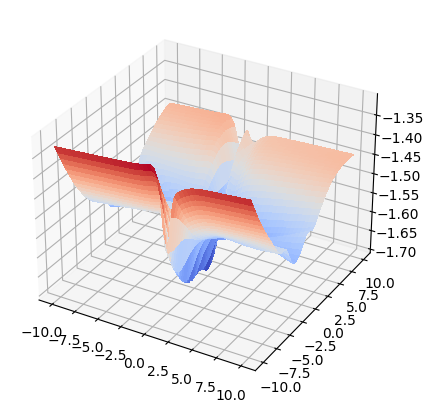

In [ ]:
x = np.linspace(-10, 10, num=200)
y = np.linspace(-10, 10, num=200)

xx, yy = np.meshgrid(x, y)

xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)

input = np.concatenate([xx, yy], axis=1)
input = torch.Tensor(input)
input = input.to(device)

zz = model(input).detach().cpu().numpy()

import matplotlib.pyplot as plt
from matplotlib import cm

xx = xx.reshape(200, 200)
yy = yy.reshape(200, 200)
zz = zz.reshape(200, 200)
fig, ax = plt.subplots(subplot_kw={"projection":"3d"}, figsize = (5,5))
surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

### Train Outer Fold 2

In [ ]:
# ##############################
train_dataset = train_datasets[1]
test_dataset = test_datasets[1]
model_name_base = "Out_Fold2: "
hidden_layer_num = 56
# ##############################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=run_config["batch_size"], shuffle=True)

model_name_fold = model_name_base + "Test" + "_"

model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
run_config["model"] = model_name
run_config["hidden_layer"] = hidden_layer_num
run = wandb.init(
    project="NN-Assignment-CV",
    job_type="Error Test",
    name=run_config['model'],
    config=run_config
    )
model, train_err, val_err = train(run_config, train_loader, test_loader)

### Visualization with trained model2

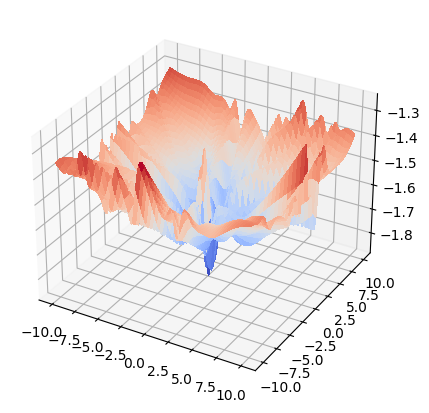

In [ ]:
x = np.linspace(-10, 10, num=200)
y = np.linspace(-10, 10, num=200)

xx, yy = np.meshgrid(x, y)

xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)

input = np.concatenate([xx, yy], axis=1)
input = torch.Tensor(input)
input = input.to(device)

zz = model(input).detach().cpu().numpy()

import matplotlib.pyplot as plt
from matplotlib import cm

xx = xx.reshape(200, 200)
yy = yy.reshape(200, 200)
zz = zz.reshape(200, 200)
fig, ax = plt.subplots(subplot_kw={"projection":"3d"}, figsize = (5,5))
surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

### Train Outer Fold 3

In [ ]:
# ##############################
train_dataset = train_datasets[2]
test_dataset = test_datasets[2]
model_name_base = "Out_Fold3: "
hidden_layer_num = 40
# ##############################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=run_config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=run_config["batch_size"], shuffle=True)

model_name_fold = model_name_base + "Test" + "_"

model_name = model_name_fold + f"model:2-{hidden_layer_num}-1"
run_config["model"] = model_name
run_config["hidden_layer"] = hidden_layer_num
run = wandb.init(
    project="NN-Assignment-CV",
    job_type="Error Test",
    name=run_config['model'],
    config=run_config
    )
model, train_err, val_err = train(run_config, train_loader, test_loader)

### Visualization with trained model3

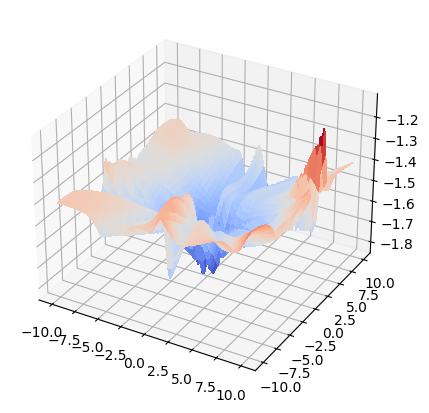

In [ ]:
x = np.linspace(-10, 10, num=200)
y = np.linspace(-10, 10, num=200)

xx, yy = np.meshgrid(x, y)

xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)

input = np.concatenate([xx, yy], axis=1)
input = torch.Tensor(input)
input = input.to(device)

zz = model(input).detach().cpu().numpy()

import matplotlib.pyplot as plt
from matplotlib import cm

xx = xx.reshape(200, 200)
yy = yy.reshape(200, 200)
zz = zz.reshape(200, 200)
fig, ax = plt.subplots(subplot_kw={"projection":"3d"}, figsize = (5,5))
surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()